In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score , classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')
FEATURES = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
X = data[FEATURES].astype(float)
y = data['Exited']
print(f'X-Shape: {np.shape(X)} y-shape: {np.shape(y)}')

X-Shape: (165034, 8) y-shape: (165034,)


 I decided to go through with a train/validation/test set because i did not want to expose the model to the test set so early on in training.

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
print(f'X_train:{np.shape(X_train)}, X_val:{np.shape(X_val)}, X_test:{np.shape(X_test)}')

label_map = {0:"Stayed", 1: "Exited"}
target_names = [label_map[i] for i in sorted(label_map)]

X_train:(132027, 8), X_val:(16503, 8), X_test:(16504, 8)


I tried three different algorithms (Logistic Regression, Random Forest Classifier, and XGBoost Classifier). Logistic regression was giving very lack luster results and there was not enough room to tune the model without having to deeply engineer the features. XGBoost performed better the Logistic Regression but a little worse that Random Forest. Random Forest did perform the best i believe this is due to the dataset not needing to be boosted. XGBoost was a little to aggressive for this model. The dataset is pretty clean and does not have deep interactions.

In [4]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=300, max_depth=19)),
])
pipe.fit(X_train, y_train)
y_prob = pipe.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.3).astype(int)

print(classification_report(y_test, y_pred, target_names=target_names))

val_auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
print("Validation AUC:", val_auc)

              precision    recall  f1-score   support

      Stayed       0.91      0.86      0.88     13064
      Exited       0.56      0.68      0.61      3440

    accuracy                           0.82     16504
   macro avg       0.73      0.77      0.75     16504
weighted avg       0.84      0.82      0.83     16504

Validation AUC: 0.8649298422613538


In [5]:
train_score = pipe.score(X_train, y_train)
val_score = pipe.score(X_val, y_val)
print(f'Train Score:{train_score}, Validation Score:{val_score}')

Train Score:0.9515174926340825, Validation Score:0.8540265406289765


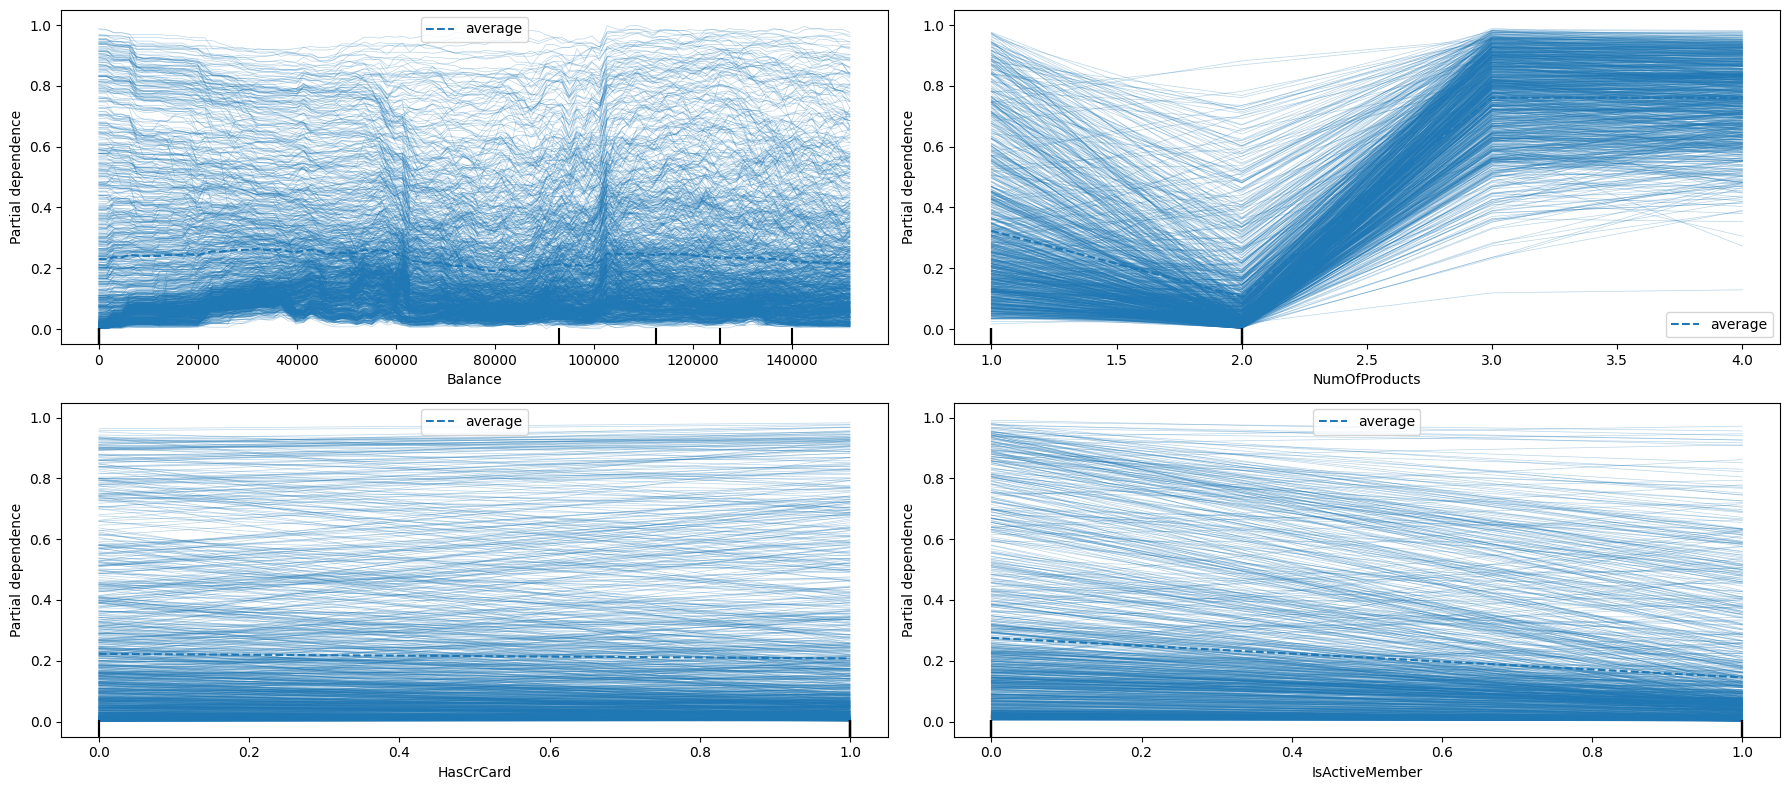

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(18, 8))
ax = ax.ravel()

PartialDependenceDisplay.from_estimator(
    pipe,
    X_train,
    features=FEATURES[3:7],
    kind="both",     
    ax=ax
)

plt.tight_layout()
plt.show()

In [ ]:
new_df = pd.read_csv('test.csv')
X_new = new_df[FEATURES]
new_df['Predicted Churn'] = pipe.predict(X_new)
new_df['Predicted Churn Probability'] = pipe.predict_proba(X_new)[:,1]
new_df.to_csv('test.csv', index=False)